In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.fc1 = nn.Linear(720, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 720)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch, log_interval):
    model.train()
    current_conv = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        current_conv.append(loss.detach())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return current_conv

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="mean").item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [37]:
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))
                                           ])),
                            batch_size=500, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                            ])),
                batch_size=16, shuffle=True)

Files already downloaded and verified


In [41]:
epochs = 5
log_interval = 10
lr = 1e-3
momentum = 0.9

In [43]:
models = {
    # "SGD": Net(),
    "SGD momentum": Net(),
    "Adam": Net(),
    # "Adagrad": Net()
}

optimizers = {
    # "SGD": optim.SGD(models["SGD"].parameters(), lr=lr),
    "SGD momentum": optim.SGD(models["SGD momentum"].parameters(), lr=lr, momentum=momentum),
    "Adam": optim.Adam(models["Adam"].parameters(), lr=lr),
    # "Adagrad": optim.Adagrad(models["Adagrad"].parameters(), lr=lr)
}
# schedulers = {
#     "SGD momentum": optim.lr_scheduler.CosineAnnealingLR(optimizers["SGD momentum"], 100),
#     "Adam": optim.lr_scheduler.CosineAnnealingLR(optimizers["Adam"], 100),
# }

conv = {opt_name: [] for opt_name in optimizers}
for opt in optimizers:
    print(opt)
    for epoch in range(1, epochs + 1):
        cur_conv = train(models[opt], train_loader, optimizers[opt], epoch, log_interval)
        conv[opt] = conv[opt] + cur_conv
#         display.clear_output(wait=True)
#         plt.plot(conv)
#     #     plt.yscale("log")
#         plt.show()
        test(models[opt], test_loader)
        # schedulers[opt].step()

SGD momentum
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305991
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.306411
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.312419
Train Epoch: 1 [15000/50000 (30%)]	Loss: 2.316790
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.305326
Train Epoch: 1 [25000/50000 (50%)]	Loss: 2.305817
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.298646
Train Epoch: 1 [35000/50000 (70%)]	Loss: 2.303752
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.292845
Train Epoch: 1 [45000/50000 (90%)]	Loss: 2.310262

Test set: Average loss: 0.1435, Accuracy: 1358/10000 (14%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.291291
Train Epoch: 2 [5000/50000 (10%)]	Loss: 2.297474
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2.294560
Train Epoch: 2 [15000/50000 (30%)]	Loss: 2.290971
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.279747
Train Epoch: 2 [25000/50000 (50%)]	Loss: 2.308104
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.289479
Train Epoch: 2 [35000/50000 (70%)]	Loss: 2.289412
Train Epoch: 2 [40000/50000 (80%)]	Los

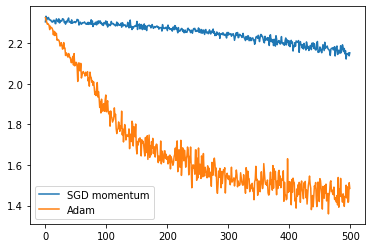

In [44]:
for opt_name in conv:
    plt.plot(conv[opt_name], label=opt_name)
plt.legend()